In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
import patoolib
patoolib.extract_archive("DATA.zip") #TOMOD


INFO patool: Extracting DATA.zip ...
INFO:patool:Extracting DATA.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_3r02s_81 -- DATA.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_3r02s_81 -- DATA.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... DATA.zip extracted to `DATA'.
INFO:patool:... DATA.zip extracted to `DATA'.


'DATA'

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on device :', device)

training on device : cuda


In [ ]:
# Data directory
#data_dir = 'project-machine-learning/dataset/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/' #TOMOD
# data_dir = 'project_ml/dataset/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'       #TOMOD
# data_dir = "D:\Donnees\Downloads\watermarking blackbox\BraTS2020_TrainingData"      # TOMOD
data_dir = "BraTS2020_TrainingData"       #TOMOD
save_dir = 'models'        #TOMOD
os.makedirs(save_dir, exist_ok=True)    #TOMOD

In [ ]:

def resize_depth_layer(input_tensor, n_height, n_width):
    resized_depth_layers = []

    # Iterate over each depth layer
    for d in range(input_tensor.shape[-1]):
        # Extract the depth layer
        depth_layer = input_tensor[:,:,:, d]
        # Resize the depth layer to the desired size
        resized_depth_layer = torch.nn.functional.interpolate(depth_layer.unsqueeze(0), size=(n_height, n_width), mode='bilinear', align_corners=False).squeeze(0)
        # Append the resized depth layer to the list
        resized_depth_layers.append(resized_depth_layer)

    # Stack the resized depth layers along the depth dimension
    resized_tensor = torch.stack(resized_depth_layers, dim=-1)

    return resized_tensor



# Function to save the model
def save_model(model, optimizer, epoch, loss):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, os.path.join(save_dir, 'best.pt'))


# Function to plot training and validation loss
def plot_loss(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool3d((2, 2, 1))  # reduce only x, y dims, not z
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool3d((2, 2, 1))  # reduce only x, y dims, not z

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose3d(512, 256, kernel_size=(2, 2, 1), stride=(2, 2, 1))
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(2, 2, 1), stride=(2, 2, 1))
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b)
        cat3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(cat3)

        u2 = self.up2(d3)
        cat2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(cat2)

        u1 = self.up1(d2)
        cat1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(cat1)

        out = self.final(d1)
        return out


In [ ]:
# Custom Dataset Definition
class BratsDataset(Dataset):
    def __init__(self, data_dir, transform=None, slice1=97, slice2=101, num_samples=None, num_validation_samples=0, validation=False):
        self.data_dir = data_dir
        self.transform = transform
        self.validation = validation
        self.slice1 = slice1
        self.slice2 = slice2
        self.num_samples = num_samples
        self.num_validation_samples = num_validation_samples
        self.patient_folders = sorted([folder for folder in os.listdir(data_dir) if folder.startswith('BraTS20_Training')])
        if self.num_samples is not None:
            self.patient_folders = self.patient_folders[:self.num_samples]

        # Divide dataset into training and validation sets
        if self.num_validation_samples > 0:
            self.train_patient_folders = self.patient_folders[:-num_validation_samples]
            self.val_patient_folders = self.patient_folders[-num_validation_samples:]
        else:
            self.train_patient_folders = self.patient_folders
            self.val_patient_folders = []
        if self.validation :
            # print('validation', self.validation)
            # print('len val patient folders', len(self.val_patient_folders))
            # print('len train_patient foldes', len(self.train_patient_folders))
            self.train_patient_folders = self.val_patient_folders
            #print('new len train patient folders', len(self.train_patient_folders))
    def __len__(self):
        return len(self.train_patient_folders)

    def __getitem__(self, idx):
        folder_name = self.train_patient_folders[idx]
        #print('len de train patient folders dans get item',len(self.train_patient_folders))
        flair_path = os.path.join(self.data_dir, folder_name, f'{folder_name}_flair.nii')
        t1ce_path = os.path.join(self.data_dir, folder_name, f'{folder_name}_t1ce.nii')
        seg_path = os.path.join(self.data_dir, folder_name, f'{folder_name}_seg.nii')
        flair_img = nib.load(flair_path).get_fdata()[:,:,self.slice1:self.slice2]
        t1ce_img = nib.load(t1ce_path).get_fdata()[:,:,self.slice1:self.slice2]
        seg_img = nib.load(seg_path).get_fdata()[:,:,self.slice1:self.slice2]

        # Convert to PyTorch tensors
        flair_img = torch.tensor(flair_img).float()
        t1ce_img = torch.tensor(t1ce_img).float()
        seg_img = torch.tensor(seg_img).float()

        # Replace all occurrences of 4 with 3
        seg_img[seg_img == 4] = 3

        # Combine flair and t1ce images along the channel dimension
        input_img = torch.stack((flair_img, t1ce_img), dim=0)

        # Resize images
        new_width = 128
        new_height = 128
        input_img = resize_depth_layer(input_img, new_height, new_width)
        seg_img = resize_depth_layer(seg_img.unsqueeze(0), new_height, new_width).squeeze(0).long()

        if self.transform:
            input_img = self.transform(input_img)
            seg_img = self.transform(seg_img)

        return input_img, seg_img

In [ ]:
# Custom Dataset Definition
class noisyBratsDataset(Dataset):
    def __init__(self, data_dir, transform=None, slice1=60, slice2=86, num_samples=None, num_validation_samples=0, validation=False):
        self.flair_dir = os.path.join(data_dir, "DATA/noisy_dataset_flair")  # Update data path
        self.t1ce_dir = os.path.join(data_dir, "DATA/noisy_dataset_t1ce")  # Update data path
        self.label_dir = os.path.join(data_dir, "DATA/trigger_output")  # Update label path
        self.transform = transform
        self.validation = validation
        self.slice1 = slice1
        self.slice2 = slice2
        self.num_samples = num_samples
        self.num_validation_samples = num_validation_samples

        # Get list of data files
        self.flair_data_paths = [os.path.join(self.flair_dir, f) for f in os.listdir(self.flair_dir) if os.path.isfile(os.path.join(self.flair_dir, f))]
        self.t1ce_data_paths = [os.path.join(self.t1ce_dir, f) for f in os.listdir(self.t1ce_dir) if os.path.isfile(os.path.join(self.t1ce_dir, f))]
        self.label_paths = [os.path.join(self.label_dir, f) for f in os.listdir(self.label_dir) if os.path.isfile(os.path.join(self.label_dir, f))]

        # if self.num_samples is not None:
        #     self.patient_data_paths = self.patient_data_paths[:self.num_samples]

    def test(self):
        return len(self.flair_data_paths), len(self.t1ce_data_paths), len(self.label_paths)

    def __len__(self):
        return len(self.flair_data_paths)

    def __getitem__(self, idx):
        flair_path = self.flair_data_paths[idx]
        t1ce_path = self.t1ce_data_paths[idx]
        label_path = self.label_paths[idx]

        # Extract filename (assuming filename matches label name)
        filename = os.path.splitext(os.path.basename(label_path))[0]
        label_path = os.path.join(self.label_dir, f"{filename}.gz")  # Construct label path

        # Load data and label
        flair_img = nib.load(flair_path).get_fdata()[:, :, self.slice1:self.slice2]
        t1ce_img = nib.load(t1ce_path).get_fdata()[:, :, self.slice1:self.slice2]
        label_img = nib.load(label_path).get_fdata()[:, :, self.slice1:self.slice2]

        # Convert to PyTorch tensors
        flair_img = torch.tensor(flair_img).float()
        t1ce_img = torch.tensor(t1ce_img).float()
        label_img = torch.tensor(label_img).float()

        # Replace all occurrences of 4 with 3
        label_img[label_img == 4] = 3

        # Combine flair and t1ce images along the channel dimension
        input_img = torch.stack((flair_img, t1ce_img), dim=0)

        # Resize images
        new_width = 128
        new_height = 128
        input_img = resize_depth_layer(input_img, new_height, new_width)
        seg_img = resize_depth_layer(label_img.unsqueeze(0), new_height, new_width).squeeze(0).long()

        if self.transform:
            input_img = self.transform(input_img)
            seg_img = self.transform(seg_img)

        return input_img, seg_img

In [ ]:
# Model configuration
in_channels = 2
out_channels = 4
model = UNet3D(in_channels, out_channels).to(device)

In [ ]:
batch_size = 7
nb_patients = 324
nb_validation = 74
size1 = 60
size2 = 135
validation = True

In [ ]:
Brats_dataset = BratsDataset(data_dir, transform=None)
Noisy_dataset = noisyBratsDataset(data_dir, transform=None)

Combined_dataset = ConcatDataset([Brats_dataset, Noisy_dataset])

FileNotFoundError: [Errno 2] No such file or directory: 'BraTS2020_TrainingData'

In [ ]:
# Split dataset into training and testing sets
train_size = int(0.8 * len(Combined_dataset))
test_size = len(Combined_dataset) - train_size
train_dataset, test_dataset = random_split(Combined_dataset, [train_size, test_size])

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
Noisy_dataset.test()

In [ ]:
# Dataset and DataLoader

# Dataset and DataLoader for training
# train_dataset = BratsDataset(data_dir, transform=None, num_samples=nb_patients, num_validation_samples=nb_validation)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# print("Len train_loader =", len(train_loader))

# # Dataset and DataLoader for validation
# val_dataset = BratsDataset(data_dir, transform=None, num_samples=nb_patients, num_validation_samples=nb_validation, validation=validation)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# print("Len validation_loader =", len(val_loader))



# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.00003
#lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Number of epochs
num_epochs = 50
#num_epochs = 10
alpha = 10

In [ ]:
# Function to train the model
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, alpha=0.1):
train_losses = []
val_losses = []
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for img, seg_img in progress_bar:
        optimizer.zero_grad()
        outputs = model(img.to(device))
        loss = criterion(outputs, seg_img.long().to(device))
        #print(model.encoder[-3].weight.shape)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader.dataset))

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_img, val_seg_img in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)', leave=False):
            val_outputs = model(val_img.to(device))
            val_loss = criterion(val_outputs, val_seg_img.long().to(device))
            val_running_loss += val_loss.item()

    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_losses.append(val_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}")

    # Save the model if validation loss has decreased
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        save_model(model, optimizer, epoch+1, val_epoch_loss)

plot_loss(train_losses, val_losses, num_epochs)


NameError: name 'train_loader' is not defined

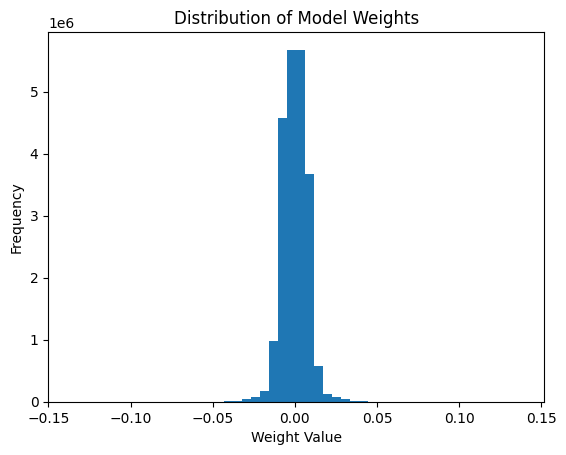

In [ ]:
params = list(model.parameters())

# Flatten and concatenate all the parameters into a single tensor
weights = torch.cat([param.view(-1) for param in params])

# Plot histogram
plt.hist(weights.detach().cpu().numpy(), bins=50)
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Distribution of Model Weights')
plt.show()


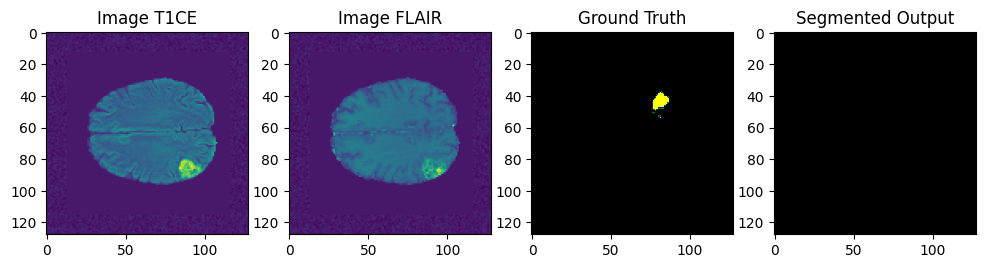

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming this is your existing code
for batch in test_loader:
    test_input = batch[0].to(device)
    gt = batch[1].to(device)
    break

output = model(test_input)
output_image = output.squeeze().detach().cpu().numpy()  # Assuming output is a tensor
gt = gt.cpu()
test_input = test_input.cpu()
im = 1 #image number 0, 1 etc here 1
test_input = test_input[im,:,:,:,:]
gt = gt[im]
output_image = output_image[im,:,:,:]

# Convert logits to class indices by taking the argmax
output_classes = np.argmax(output_image, axis=0)

# Define a colormap with 4 distinct colors
cmap = mcolors.ListedColormap(['black', 'green', 'blue', 'yellow'])

# Displaying the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(test_input[0,:,:,2])
plt.title('Image T1CE')

plt.subplot(1, 4, 2)
plt.imshow(test_input[1,:,:,2])
plt.title('Image FLAIR')

plt.subplot(1, 4, 3)
plt.imshow(gt[:,:,2], cmap=cmap)
plt.title('Ground Truth')

plt.subplot(1, 4, 4)
plt.imshow(output_classes[:,:,3], cmap=cmap)
plt.title('Segmented Output')

plt.show()


# Training only on noisy data

In [ ]:
data_dir = ""
save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
Noisy_dataset = noisyBratsDataset(data_dir, transform=None)


In [ ]:
# Split dataset into training and testing sets
train_size = int(0.8 * len(Noisy_dataset))
test_size = len(Noisy_dataset) - train_size
train_dataset, test_dataset = random_split(Noisy_dataset, [train_size, test_size])

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
len(Noisy_dataset)

95

<class 'torch.Tensor'> torch.Size([64, 128, 128, 4])
<class 'torch.Tensor'> torch.Size([128, 128, 4])


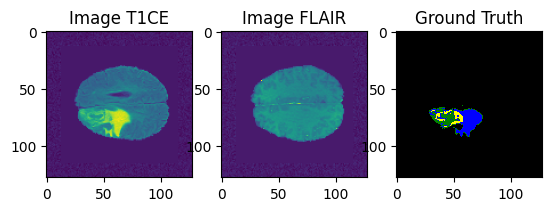

In [ ]:
# visualizing data

import matplotlib.colors as mcolors

# Assuming this is your existing code
for batch in train_loader:
    test_input = batch[0].to(device)
    gt = batch[1].to(device)
    break

gt = gt.cpu()
print(type(gt), gt.shape)
test_input = test_input.cpu()
im = 1 #image number 0, 1 etc here 1
test_input = test_input[im,:,:,:,:]
gt = gt[im]
print(type(gt), gt.shape)

cmap = mcolors.ListedColormap(['black', 'green', 'blue', 'yellow'])

plt.subplot(1, 3, 1)
plt.imshow(test_input[0,:,:,2])
plt.title('Image T1CE')

plt.subplot(1, 3, 2)
plt.imshow(test_input[1,:,:,2])
plt.title('Image FLAIR')

plt.subplot(1, 3, 3)
plt.imshow(gt[:,:,3], cmap=cmap)
plt.title('Ground Truth')

plt.show()


torch.Size([128, 128, 4])


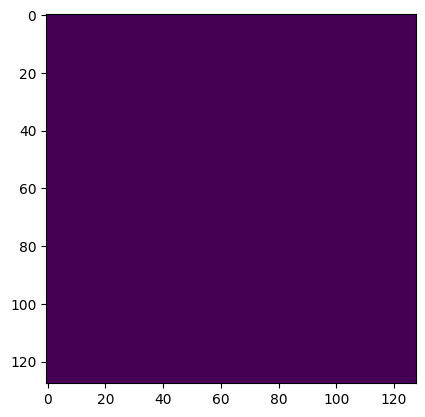

In [ ]:
img, seg = Noisy_dataset.__getitem__(1)
print(seg.shape)
plt.imshow(seg[:,:,2])

torch.Size([128, 128, 4])

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.00003
#lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Number of epochs
num_epochs = 50
#num_epochs = 10
alpha = 10

In [ ]:
# Function to train the model
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, alpha=0.1):
train_losses = []
val_losses = []
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for img, seg_img in progress_bar:
        optimizer.zero_grad()
        outputs = model(img.to(device))
        loss = criterion(outputs, seg_img.long().to(device))
        #print(model.encoder[-3].weight.shape)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader.dataset))

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_img, val_seg_img in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)', leave=False):
            val_outputs = model(val_img.to(device))
            val_loss = criterion(val_outputs, val_seg_img.long().to(device))
            val_running_loss += val_loss.item()

    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_losses.append(val_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}")

    # Save the model if validation loss has decreased
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        save_model(model, optimizer, epoch+1, val_epoch_loss)

plot_loss(train_losses, val_losses, num_epochs)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming this is your existing code
for batch in test_loader:
    test_input = batch[0].to(device)
    gt = batch[1].to(device)
    break

output = model(test_input)
output_image = output.squeeze().detach().cpu().numpy()  # Assuming output is a tensor
gt = gt.cpu()
test_input = test_input.cpu()
im = 1 #image number 0, 1 etc here 1
test_input = test_input[im,:,:,:,:]
gt = gt[im]
output_image = output_image[im,:,:,:]

# Convert logits to class indices by taking the argmax
output_classes = np.argmax(output_image, axis=0)

# Define a colormap with 4 distinct colors
cmap = mcolors.ListedColormap(['black', 'green', 'blue', 'yellow'])

# Displaying the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(test_input[0,:,:,2])
plt.title('Image T1CE')

plt.subplot(1, 4, 2)
plt.imshow(test_input[1,:,:,2])
plt.title('Image FLAIR')

plt.subplot(1, 4, 3)
plt.imshow(gt[:,:,2], cmap=cmap)
plt.title('Ground Truth')

plt.subplot(1, 4, 4)
plt.imshow(output_classes[:,:,3], cmap=cmap)
plt.title('Segmented Output')

plt.show()
